In [1]:
'''
MacOS专用字体设置
MacOS 系统中使用的中文字体路径
适用于MacOS15版本
可直接复制到代码中使用
'''
import matplotlib.pyplot as plt
from matplotlib import font_manager
# 设置字体路径
font_path = '/System/Library/Fonts/STHeiti Medium.ttc'

# 加载字体
my_font = font_manager.FontProperties(fname=font_path)

# 设置为默认字体
plt.rcParams['font.family'] = my_font.get_name()
plt.rcParams['axes.unicode_minus'] = False  # 正确显示负号

In [2]:
import pandas as pd

In [3]:
df = pd.read_excel('信用评分卡模型.xlsx')
df.head()

,月收入,年龄,性别,历史授信额度,历史违约次数,信用评分
0,7783,29,0,32274,3,73
1,7836,40,1,6681,4,72
2,6398,25,0,26038,2,74
3,6483,23,1,24584,4,65
4,5167,23,1,6710,3,73


In [4]:
df.isnull().sum()

月收入       0
年龄        0
性别        0
历史授信额度    0
历史违约次数    0
信用评分      0
dtype: int64

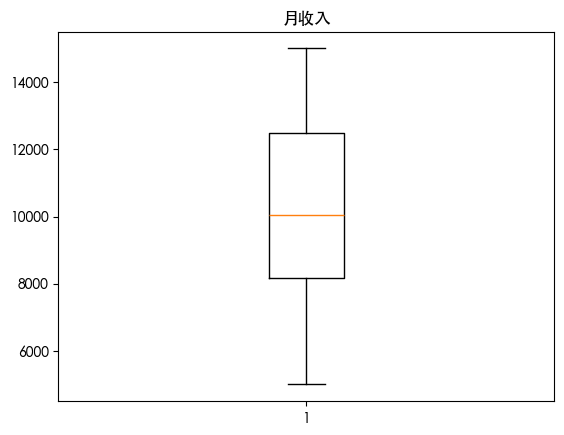

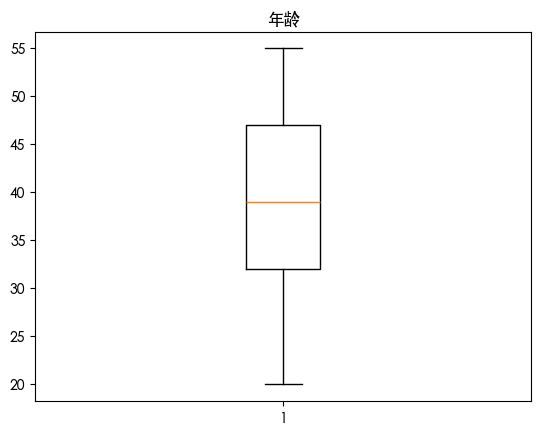

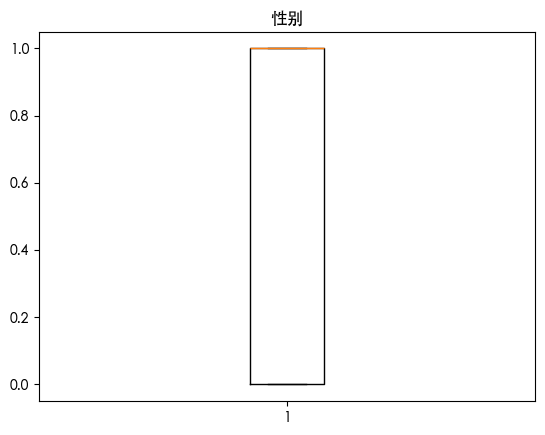

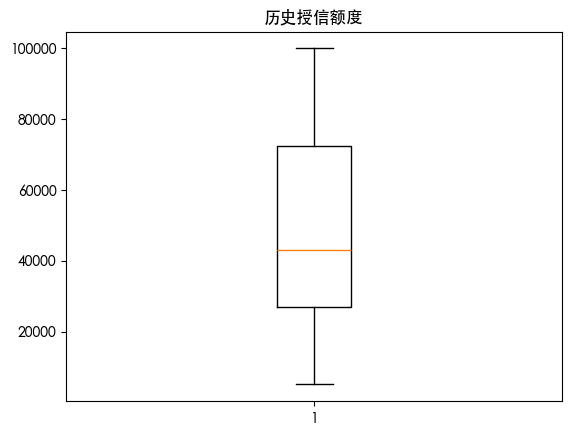

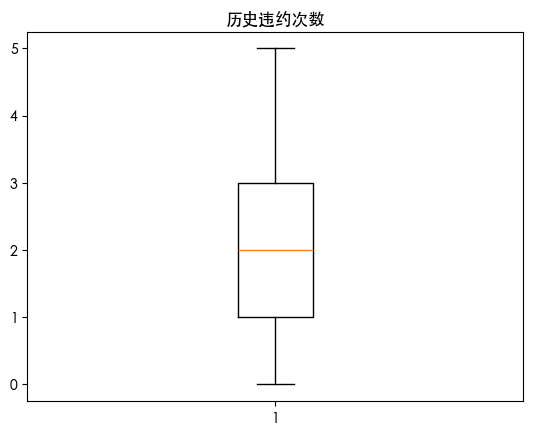

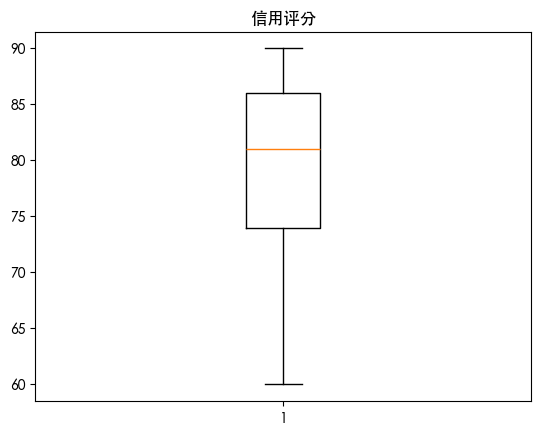

In [5]:
for col in df.columns:
    plt.boxplot(df[col])
    plt.title(col)
    plt.show()

In [6]:
from sklearn.model_selection import train_test_split
X = df.drop(columns=['信用评分'])
y = df['信用评分']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# XGBoost

In [7]:
from xgboost import XGBRegressor

xgb = XGBRegressor(objective='reg:squarederror', random_state=42)
xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_test)

from sklearn.metrics import mean_squared_error, r2_score
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f'Mean Squared Error: {mse}')
print(f'R^2 Score: {r2}')

Mean Squared Error: 30.737820683092288
R^2 Score: 0.5528881678156692


In [8]:
from sklearn.model_selection import GridSearchCV  
parameters = {'max_depth': [1, 3, 5], 'n_estimators': [50, 100, 150], 'learning_rate': [0.01, 0.05, 0.1, 0.2]}  # 指定模型中参数的范围
xgb_best = XGBRegressor()
grid_search = GridSearchCV(xgb_best, parameters, cv=5, scoring='neg_mean_squared_error')  # 5折交叉验证
grid_search.fit(X_train, y_train)
print("Best parameters:", grid_search.best_params_)


Best parameters: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 50}


In [9]:
best_xgb = grid_search.best_estimator_
y_pred_best = best_xgb.predict(X_test)
mse_best = mean_squared_error(y_test, y_pred_best)
r2_best = r2_score(y_test, y_pred_best)
print(f'Optimized Mean Squared Error: {mse_best}')
print(f'Optimized R^2 Score: {r2_best}')

Optimized Mean Squared Error: 22.005304773406532
Optimized R^2 Score: 0.6799112000668165


In [16]:
feature_importances = best_xgb.feature_importances_
features = X.columns
importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})
importance_df.sort_values(by='Importance', ascending=False, inplace=True)
importance_df

,Feature,Importance
3,历史授信额度,0.414059
0,月收入,0.218888
1,年龄,0.185026
4,历史违约次数,0.182028
2,性别,0.000000


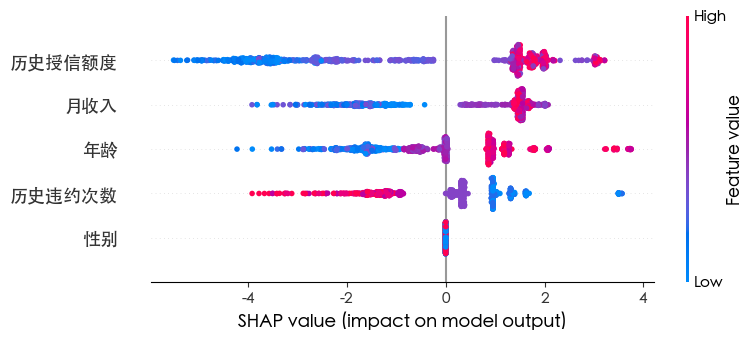

In [ ]:
import shap
explainer = shap.Explainer(best_xgb)
shap_values = explainer(X)
shap.summary_plot(shap_values, X)

# LGBM

In [18]:
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error, r2_score

lgbm = LGBMRegressor(random_state=42)
lgbm.fit(X_train, y_train)
y_pred_lgbm = lgbm.predict(X_test)
mse_lgbm = mean_squared_error(y_test, y_pred_lgbm)
r2_lgbm = r2_score(y_test, y_pred_lgbm)
print(f'LightGBM Mean Squared Error: {mse_lgbm}')
print(f'LightGBM R^2 Score: {r2_lgbm}')

feature_importances_lgbm = lgbm.feature_importances_
features = X.columns
importance_df_lgbm = pd.DataFrame({'Feature': features, 'Importance': feature_importances_lgbm})
importance_df_lgbm.sort_values(by='Importance', ascending=False, inplace=True)
importance_df_lgbm

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000190 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 555
[LightGBM] [Info] Number of data points in the train set: 800, number of used features: 5
[LightGBM] [Info] Start training from score 79.685000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

,Feature,Importance
3,历史授信额度,1102
0,月收入,1089
1,年龄,492
4,历史违约次数,142
2,性别,138


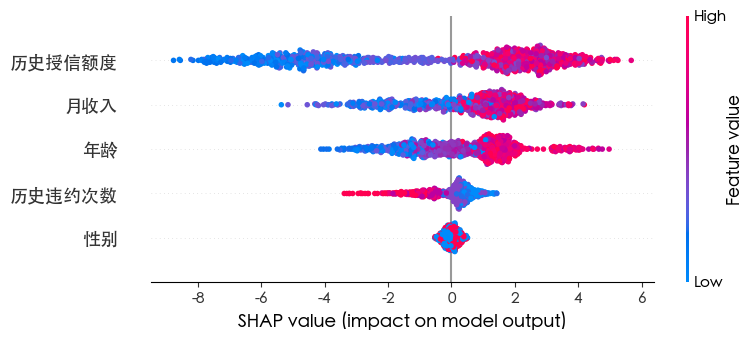

In [19]:
explainer = shap.Explainer(lgbm)
shap_values = explainer(X)
shap.summary_plot(shap_values, X)

# 随机森林

In [29]:
from sklearn.ensemble import RandomForestRegressor

rm = RandomForestRegressor(random_state=42)
rm.fit(X_train, y_train)
y_pred_rm = rm.predict(X_test)
mse_rm = mean_squared_error(y_test, y_pred_rm)
r2_rm = r2_score(y_test, y_pred_rm)
print(f'Random Forest Mean Squared Error: {mse_rm}')
print(f'Random Forest R^2 Score: {r2_rm}')

feature_importances_rm = rm.feature_importances_
features = X.columns
importance_df_rm = pd.DataFrame({'Feature': features, 'Importance': feature_importances_rm})
importance_df_rm.sort_values(by='Importance', ascending=False, inplace=True)
importance_df_rm



Random Forest Mean Squared Error: 22.497981999999997
Random Forest R^2 Score: 0.6727447252627369


,Feature,Importance
3,历史授信额度,0.394981
0,月收入,0.344305
1,年龄,0.130999
4,历史违约次数,0.120340
2,性别,0.009375


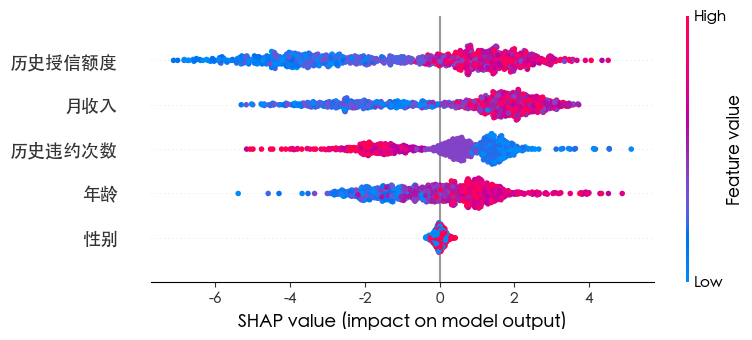

In [30]:
explainer = shap.Explainer(rm)
shap_values = explainer(X)
shap.summary_plot(shap_values, X)

# LDA

In [23]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

lda = LinearDiscriminantAnalysis()
lda.fit(X_train, y_train)
y_pred_lda = lda.predict(X_test)
mse_lda = mean_squared_error(y_test, y_pred_lda)
r2_lda = r2_score(y_test, y_pred_lda)
print(f'Linear Discriminant Analysis Mean Squared Error: {mse_lda}')
print(f'Linear Discriminant Analysis R^2 Score: {r2_lda}')

feature_importances_lda = lda.coef_[0]
features = X.columns
importance_df_lda = pd.DataFrame({'Feature': features, 'Importance': feature_importances_lda})
importance_df_lda.sort_values(by='Importance', ascending=False, inplace=True)
importance_df_lda

Linear Discriminant Analysis Mean Squared Error: 30.66
Linear Discriminant Analysis R^2 Score: 0.5540201461871341


,Feature,Importance
4,历史违约次数,1.404021
2,性别,0.617812
3,历史授信额度,-0.000052
0,月收入,-0.000985
1,年龄,-0.070723


# KNN

In [26]:
from sklearn.neighbors import KNeighborsRegressor

knn = KNeighborsRegressor(n_neighbors=5)
knn.fit(X_train, y_train)
y_pred_knn = knn.predict(X_test)
mse_knn = mean_squared_error(y_test, y_pred_knn)
r2_knn = r2_score(y_test, y_pred_knn)

print(f'KNN Mean Squared Error: {mse_knn}')
print(f'KNN R^2 Score: {r2_knn}')


KNN Mean Squared Error: 25.003800000000002
KNN R^2 Score: 0.6362951380050184
